# Breadth First Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using breadth first search

In [2]:
%%capture
################################################
# IGNORE if you are running on a local machine #
################################################
# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;

In [3]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import matplotlib.animation as animation


Here OSMnx find the largest connected component centered around the ```location point``` with specified ```distance``` on each side (w/n/e/s).

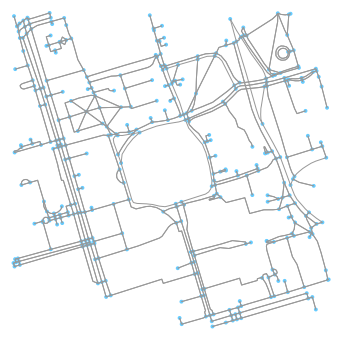

In [4]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

In [3]:
# we need to save the graph 
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

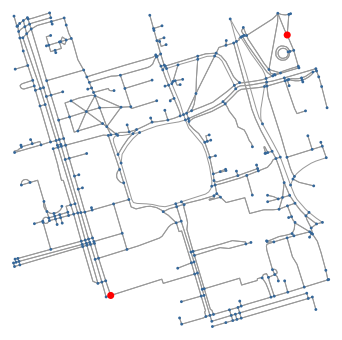

In [4]:
# coloring both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing

In [9]:
class Node:
    
    # constructor for each node
    def __init__(self, node, osmid, distance = 0, parent = None):
        
        # the dictionary of each node as in networkx graph --- still needed for internal usage
        self.node = node
        
        # the distance from the parent node --- edge length
        self.distance = distance
        
        # the parent node
        self.parent = parent
        
        # unique identifier for each node so we don't use the dictionary returned from osmnx
        self.osmid = osmid
        
        # the distance from the origin to that node --- sum of edges length
        self.from_origin = self.distance_from_origin()
    
    # returning all the nodes adjacent to the node
    def expand(self):
        children = [Node(G[child], child, distance = self.node[child][0]['length'], parent = self) \
                        for child in self.node]
        return children
    
    # returns the path from that node to the origin as a list
    def path(self):
        node = self
        path = []
        while node:
            path.append(node.osmid)
            node = node.parent
        return path[::-1]
    
    # return the summation of edges length from the origin --- used in dijkstra
    def distance_from_origin(self):
        meters = 0
        node = self
        while node:
            meters += node.distance
            node = node.parent
        return meters
    
    # the following two methods are for supporting
    # list usage and some optimization to get over
    # the networkx dictionary hurdle
    def __eq__(self, other):
        try:
            return self.osmid == other.osmid
        except:
            return self.osmid == other
            
    
    def __hash__(self):
        return hash(self.osmid)

# The Algorithm

In [10]:
# first define the origin/source nodes as Node
origin = Node(G[55808290], 55808290, distance = 0, parent = None)
destination = Node(G[389677909], 389677909)

In [18]:
route = []

frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    node = frontier.popleft()
    explored.add(node)
    if node == destination:
        route = node.path()
        found = True
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
            frontier.append(child)
            

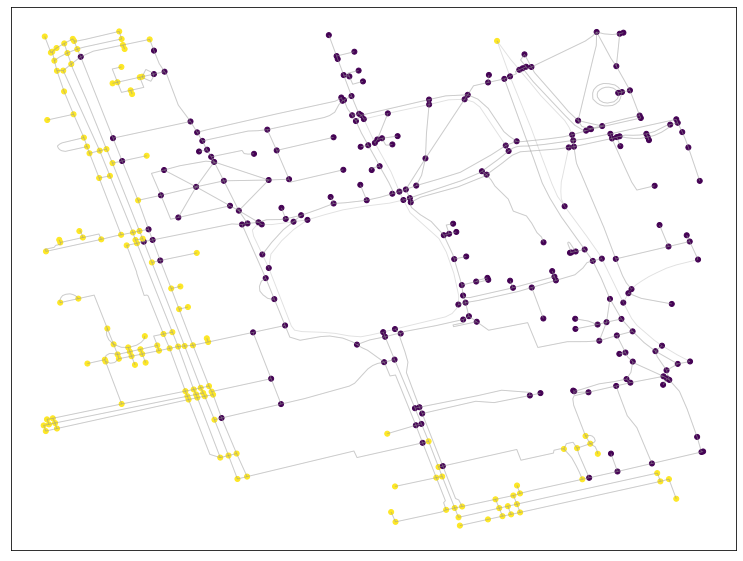

In [17]:
steps = np.array(steps)

node_Xs = [float(x) for _, x in G.nodes(data='x')]
node_Ys = [float(y) for _, y in G.nodes(data='y')]

def update_plot(i, data, scat):
    scat.set_array(data[i])
    return scat,

def animate_simple():
    numframes = len(steps) 
    fig, ax =  plt.subplots(figsize=(13, 10))
    ax.set_facecolor('w')
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
            if 'geometry' in data:
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)

    lc = LineCollection(lines, colors='#999999', linewidths=0.9, alpha=0.3)

    ax.add_collection(lc)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    scat = ax.scatter(node_Xs, node_Ys,c=steps[0], s=25)
    ani = animation.FuncAnimation(fig, update_plot, frames=list(range(numframes)), interval=500,
                                 fargs = (steps, scat))
    return ani    

HTML(animate_simple().to_html5_video())